In [1]:
from foundry.util.runtime import setup
setup()

import foundry.numpy as npx
import foundry.train.console
import foundry.train
import foundry.models
import matplotlib.pyplot as plt

import optax
import jax
import flax.linen as nn

from collections.abc import Sequence

from foundry.models.embed import SinusoidalPosEmbed
from foundry.models import activation

from foundry.random import PRNGSequence
from foundry.data import PyTreeData
from foundry.train import LossOutput
from foundry.util.registry import Registry
from foundry.diffusion.ddpm import DDPMSchedule
from foundry.core import tree

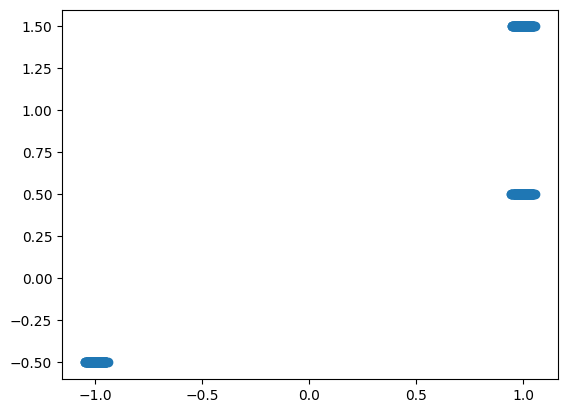

In [2]:
def sample(rng_key):
    z_rng, z_n_rng, x_rng = foundry.random.split(rng_key, 3)
    x = foundry.random.choice()
    z = foundry.random.choice(z_rng, npx.array([-1, 1]))
    x = sample_cond(z, x_rng)
    z = z + 0.02*foundry.random.normal(z_n_rng)
    return npx.stack((z, x))

data = jax.vmap(sample)(foundry.random.split(foundry.random.key(42), 1024))
data = PyTreeData(data)
rng = PRNGSequence(42)

plt.scatter(data.tree[:,0], data.tree[:,1])
plt.show()

schedule = DDPMSchedule.make_squaredcos_cap_v2(
    64, 
    prediction_type="epsilon",
    clip_sample_range=2.
)

In [3]:
class DiffusionMLP(nn.Module):
    features: Sequence[int] = (128, 128, 128)
    activation: str = "gelu"
    time_embed_dim: int = 64
    num_classes: int | None = None
    out_channels: int | None = None

    @nn.compact
    def __call__(self, x, t, cond=None, train=False):
        h = getattr(activation, self.activation)
        # works even if we have multiple timesteps
        embed = SinusoidalPosEmbed(self.time_embed_dim)(t)
        embed = nn.Sequential([
            nn.Dense(self.time_embed_dim),
            h,
            nn.Dense(self.time_embed_dim),
        ])(embed)

        x, x_uf = tree.ravel_pytree(x)
        out_features = x.shape[-1]
        if cond is not None:
            cond, _ = tree.ravel_pytree(cond)
            x = npx.concatenate([x, cond], axis=-1)
        for feat in self.features:
            shift, scale = npx.split(nn.Dense(2*feat)(embed), 2, -1)
            x = h(nn.Dense(feat)(x))
            x = x * (1 + scale) + shift
        x = nn.Dense(out_features)(x)
        x = x_uf(x)
        return x

In [4]:
model = DiffusionMLP()

vars = model.init(next(rng), npx.zeros(()), 
    npx.zeros((), dtype=npx.uint32), cond=npx.zeros(()))

iterations = 20_000

optimizer = optax.adamw(optax.cosine_decay_schedule(1e-4, iterations), weight_decay=1e-5)
opt_state = optimizer.init(vars["params"])


@foundry.train.batch_loss
def loss(vars, rng_key, sample):
    z, x = sample
    loss = schedule.loss(rng_key, 
        lambda rng_key, x, t: model.apply(vars, x, t, cond=z),
        x
    )
    return LossOutput(
        loss=loss,
        metrics={"loss": loss}
    )

data_stream = data.stream().shuffle(next(rng)).batch(512)

checkpoint_iterations = []
checkpoint_history = []
checkpoint_loss_history = []
with foundry.train.loop(data_stream,
    rng_key=next(rng), iterations=iterations
) as loop:
    for epoch in loop.epochs():
        for step in epoch.steps():
            opt_state, vars, metrics = foundry.train.step(
                loss, optimizer, opt_state, vars, 
                step.rng_key, step.batch
            )
            if step.iteration % 1000 == 0:
                foundry.train.console.log(
                    step.iteration, metrics
                )
            if step.iteration % 100 == 0:
                checkpoint_iterations.append(step.iteration)
                checkpoint_loss_history.append(metrics["loss"])
                checkpoint_history.append(
                    tree.map(npx.copy, vars)
                )
    foundry.train.console.log(
        step.iteration, metrics
    )
checkpoint_iterations = npx.array(checkpoint_iterations)
checkpoint_loss_history = npx.array(checkpoint_loss_history)

Iteration       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20000/20000 100% 0:00:00 0:01:28
Epoch           ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10000/10000 100% 0:00:00 0:01:28
Epoch Iteration ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2         100% 0:00:00 0:00:00


[21:56:14] INFO     foundry.train -      0 | loss: 1.2497076988220215
[21:56:18] INFO     foundry.train -   1000 | loss: 0.11825305223464966
[21:56:23] INFO     foundry.train -   2000 | loss: 0.0860784575343132
[21:56:27] INFO     foundry.train -   3000 | loss: 0.10714984685182571
[21:56:31] INFO     foundry.train -   4000 | loss: 0.0944974422454834
[21:56:36] INFO     foundry.train -   5000 | loss: 0.08422689884901047
[21:56:40] INFO     foundry.train -   6000 | loss: 0.10064584761857986
[21:56:44] INFO     foundry.train -   7000 | loss: 0.061960916966199875
[21:56:48] INFO     foundry.train -   8000 | loss: 0.1086340919137001
[21:56:53] INFO     foundry.train -   9000 | loss: 0.0727461576461792
[21:56:57] INFO     foundry.train -  10000 | loss: 0.09016864746809006
[21:57:01] INFO     foundry.train -  11000 | loss: 0.11097350716590881
[21:57:05] INFO     foundry.train -  12000 | loss: 0.07666576653718948
[21:57:10] INFO     foundry.train -  13000 | loss: 0.10333126783370972
[21:57:14]

In [5]:
z = npx.linspace(-1, 1, 128)
rngs = foundry.random.split(foundry.random.key(42), z.shape[0])
@jax.jit
def sample(z, rng_key):
    diffuser = lambda rng_key, x, t: model.apply(vars, x, t, cond=z)
    sampler = lambda rng_key: (z, schedule.sample(rng_key, diffuser, npx.zeros(())))
    zs, vs = jax.vmap(sampler)(foundry.random.split(rng_key, 16))
    return zs, vs

zs, vs = jax.vmap(sample)(z, rngs)
val_samples = npx.stack((zs, vs), -1).reshape(-1, 2)

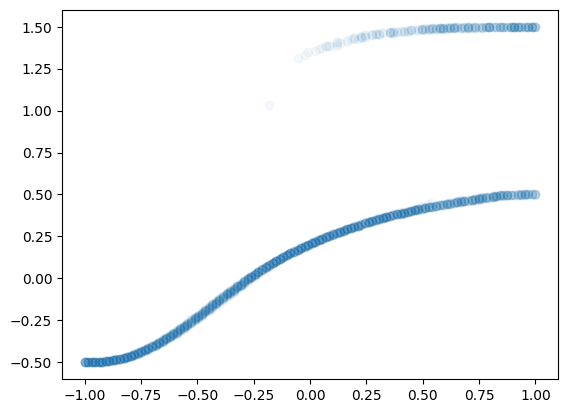

In [6]:
plt.scatter(val_samples[:,0], val_samples[:,1], alpha=0.04)
plt.show()

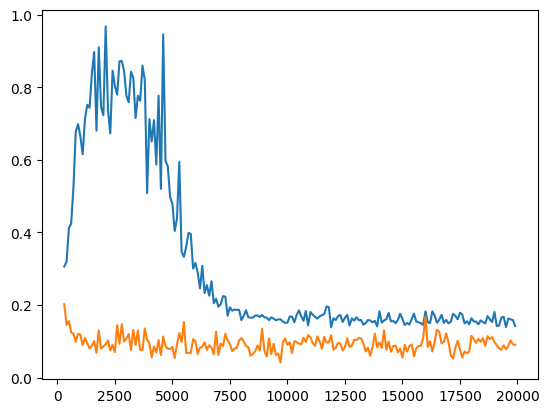

In [ ]:
val_loss = npx.array([loss(c, next(rng), val_samples).loss for c in checkpoint_history])
plt.plot(checkpoint_iterations[3:], val_loss[3:])
plt.plot(checkpoint_iterations[3:], checkpoint_loss_history[3:])
plt.show()